# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [6]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 100
    
    nodes_cnt = 3000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [7]:
setting = Setting()

In [8]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-22 01-17'

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [9]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [10]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [11]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [12]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [13]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [14]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

#### Generate 10,000 for train

In [12]:
nodes_cnt = setting.nodes_cnt

In [ ]:
train_dir = os.path.join(setting._data, "train", str(nodes_cnt))
if os.path.exists(train_dir):
    pass
else:
    os.makedirs(train_dir)

In [ ]:
for i in range(10000):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(train_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(train_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

#### Generate 100 for validation

In [ ]:
valid_dir = os.path.join(setting._data, "valid", str(nodes_cnt))
if os.path.exists(valid_dir):
    pass
else:
    os.makedirs(valid_dir)

In [ ]:
for i in range(100):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(valid_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(valid_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

## Read data

### Load test data

In [15]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [16]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [17]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [38]:
train_loader = to_dataloader(train, train_bet, batch=8)
valid_loader = to_dataloader(valid, valid_bet, batch=8)

In [ ]:
for batch in train_loader:
    print(batch.y)

In [19]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [20]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [21]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [22]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [23]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [24]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [25]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [26]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [27]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [28]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [29]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [30]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [31]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [39]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [40]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/1250 [00:00<?, ?it/s]


Epoch: 1


  8%|▊         | 1/13 [00:00<00:01,  7.26it/s]

Train: loss = 0.693143013877402, top 1 = 0.9401599999999076, top 5 = 0.9196159999999354, top 10 = 0.9134916666666433, kendal = 0.7116198666222097


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430349954408, top 1 = 0.9420000000000007, top 5 = 0.917066666666666, top 10 = 0.9119333333333332, kendal = 0.7072789507613648

Epoch: 2


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

Train: loss = 0.6931429946481388, top 1 = 0.9510666666665788, top 5 = 0.9337373333332627, top 10 = 0.9200076666666434, kendal = 0.7190453331110369


  0%|          | 1/1250 [00:00<02:37,  7.91it/s]

Valid: loss = 0.6931429717410836, top 1 = 0.9546666666666676, top 5 = 0.9288000000000001, top 10 = 0.9181666666666668, kendal = 0.7150813071023673

Epoch: 3


  8%|▊         | 1/13 [00:00<00:01,  7.88it/s]

Train: loss = 0.6931429877254698, top 1 = 0.9592099999999179, top 5 = 0.9393419999999213, top 10 = 0.9290763333333, kendal = 0.72518205432922


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430938728351, top 1 = 0.9636666666666673, top 5 = 0.9361333333333335, top 10 = 0.9269333333333332, kendal = 0.7211909836612204

Epoch: 4


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429791101853, top 1 = 0.9628766666665873, top 5 = 0.9429286666665857, top 10 = 0.9331046666666325, kendal = 0.727883607113485


  0%|          | 1/1250 [00:00<03:38,  5.72it/s]

Valid: loss = 0.6931430276189511, top 1 = 0.9666666666666671, top 5 = 0.9394666666666661, top 10 = 0.9312999999999999, kendal = 0.7235517394687118

Epoch: 5


  8%|▊         | 1/13 [00:00<00:01,  6.10it/s]

Train: loss = 0.6931429821085323, top 1 = 0.9646399999999243, top 5 = 0.9454113333332481, top 10 = 0.9369653333332959, kendal = 0.6840375736801155


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430157926033, top 1 = 0.9663333333333339, top 5 = 0.9420666666666664, top 10 = 0.9332, kendal = 0.6794047171279316

Epoch: 6


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429848258756, top 1 = 0.9661633333332591, top 5 = 0.947881333333243, top 10 = 0.9406266666666266, kendal = 0.7029369277314665


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430164613651, top 1 = 0.9686666666666671, top 5 = 0.9450666666666665, top 10 = 0.9378333333333333, kendal = 0.6980248971879519

Epoch: 7


  8%|▊         | 1/13 [00:00<00:01,  8.07it/s]

Train: loss = 0.6931429843873183, top 1 = 0.967383333333261, top 5 = 0.949758666666582, top 10 = 0.9441836666666286, kendal = 0.7304477837945924


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429557422177, top 1 = 0.968333333333334, top 5 = 0.9472666666666665, top 10 = 0.9416333333333327, kendal = 0.7255982349672112

Epoch: 8


  8%|▊         | 1/13 [00:00<00:01,  6.75it/s]

Train: loss = 0.6931429741538806, top 1 = 0.9686933333332614, top 5 = 0.951844666666577, top 10 = 0.9474213333332926, kendal = 0.7671145621429378


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429872794169, top 1 = 0.9686666666666673, top 5 = 0.9503333333333334, top 10 = 0.9454666666666666, kendal = 0.7623926820051128

Epoch: 9


  8%|▊         | 1/13 [00:00<00:01,  8.14it/s]

Train: loss = 0.6931429817564927, top 1 = 0.9697966666666001, top 5 = 0.9536166666665755, top 10 = 0.9494479999999529, kendal = 0.7650344188507296


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430087191199, top 1 = 0.9693333333333339, top 5 = 0.9533999999999999, top 10 = 0.947533333333333, kendal = 0.7602237101255973

Epoch: 10


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429728059719, top 1 = 0.9709133333332695, top 5 = 0.9550539999999064, top 10 = 0.9517316666666151, kendal = 0.7883583578526148


  0%|          | 1/1250 [00:00<02:34,  8.10it/s]

Valid: loss = 0.6931430507056975, top 1 = 0.9720000000000004, top 5 = 0.9544666666666665, top 10 = 0.9499999999999998, kendal = 0.7837899210848062

Epoch: 11


  8%|▊         | 1/13 [00:00<00:01,  6.77it/s]

Train: loss = 0.6931429737926866, top 1 = 0.9719299999999359, top 5 = 0.9566679999999029, top 10 = 0.9523516666666197, kendal = 0.798271371257083


  0%|          | 1/1250 [00:00<02:48,  7.42it/s]

Valid: loss = 0.6931430232637552, top 1 = 0.9720000000000004, top 5 = 0.9548666666666663, top 10 = 0.9511333333333334, kendal = 0.7937273535622984

Epoch: 12


  8%|▊         | 1/13 [00:00<00:01,  6.07it/s]

Train: loss = 0.6931429743618904, top 1 = 0.9725866666666029, top 5 = 0.9578313333332353, top 10 = 0.9527583333332869, kendal = 0.8084451630988114


  0%|          | 1/1250 [00:00<02:44,  7.59it/s]

Valid: loss = 0.6931430253049353, top 1 = 0.9716666666666672, top 5 = 0.956933333333333, top 10 = 0.9520333333333331, kendal = 0.8041322129598757

Epoch: 13


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429681761981, top 1 = 0.9731233333332683, top 5 = 0.9590346666665744, top 10 = 0.9543433333332818, kendal = 0.8028497183505605


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430824719742, top 1 = 0.9720000000000006, top 5 = 0.9582666666666668, top 10 = 0.9537333333333331, kendal = 0.7983934778259417

Epoch: 14


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429656455098, top 1 = 0.9734333333332695, top 5 = 0.9599193333332406, top 10 = 0.9541739999999487, kendal = 0.8187093486273205


  0%|          | 1/1250 [00:00<02:36,  7.98it/s]

Valid: loss = 0.6931430550275023, top 1 = 0.9723333333333339, top 5 = 0.9586000000000001, top 10 = 0.9538999999999999, kendal = 0.8142768522840946

Epoch: 15


  8%|▊         | 1/13 [00:00<00:01,  8.02it/s]

Train: loss = 0.6931429682394724, top 1 = 0.9740666666666029, top 5 = 0.96074866666657, top 10 = 0.9544479999999439, kendal = 0.8238467028120493


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429601774416, top 1 = 0.974333333333334, top 5 = 0.9592666666666664, top 10 = 0.9536999999999998, kendal = 0.8194159030788037

Epoch: 16


  8%|▊         | 1/13 [00:00<00:02,  5.87it/s]

Train: loss = 0.6931429694547735, top 1 = 0.9744599999999386, top 5 = 0.9615486666665718, top 10 = 0.9548056666666158, kendal = 0.828509593953539


  0%|          | 1/1250 [00:00<04:02,  5.15it/s]

Valid: loss = 0.693142986214863, top 1 = 0.9743333333333339, top 5 = 0.9598, top 10 = 0.9536666666666668, kendal = 0.8244968011559409

Epoch: 17


  8%|▊         | 1/13 [00:00<00:01,  7.96it/s]

Train: loss = 0.6931429691347283, top 1 = 0.974773333333273, top 5 = 0.9621466666665744, top 10 = 0.9557526666666089, kendal = 0.8141406928087136


  0%|          | 1/1250 [00:00<03:36,  5.77it/s]

Valid: loss = 0.6931429857746554, top 1 = 0.9750000000000008, top 5 = 0.9604666666666661, top 10 = 0.9549333333333329, kendal = 0.8103820384572633

Epoch: 18


  8%|▊         | 1/13 [00:00<00:01,  6.55it/s]

Train: loss = 0.6931429749466997, top 1 = 0.9752566666666073, top 5 = 0.962603999999905, top 10 = 0.9562409999999422, kendal = 0.8248347062798702


  0%|          | 1/1250 [00:00<03:42,  5.61it/s]

Valid: loss = 0.6931429918188573, top 1 = 0.975333333333334, top 5 = 0.9605999999999996, top 10 = 0.9557999999999999, kendal = 0.8211870756918971

Epoch: 19


  8%|▊         | 1/13 [00:00<00:01,  7.25it/s]

Train: loss = 0.693142965210569, top 1 = 0.97536999999994, top 5 = 0.9629466666665704, top 10 = 0.9562149999999441, kendal = 0.8353652716238774


  0%|          | 1/1250 [00:00<03:22,  6.17it/s]

Valid: loss = 0.6931429869259044, top 1 = 0.9760000000000006, top 5 = 0.9618666666666662, top 10 = 0.9557666666666667, kendal = 0.8319427009003004

Epoch: 20


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429664421317, top 1 = 0.9756799999999397, top 5 = 0.9634699999999015, top 10 = 0.9566513333332743, kendal = 0.8346034014449242


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429821030758, top 1 = 0.9756666666666673, top 5 = 0.9624666666666662, top 10 = 0.956233333333333, kendal = 0.8314319128598423

Epoch: 21


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429695887821, top 1 = 0.9760233333332738, top 5 = 0.9636313333332366, top 10 = 0.9569709999999415, kendal = 0.8391308893186642


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.693142983057306, top 1 = 0.9756666666666673, top 5 = 0.9631333333333332, top 10 = 0.9566999999999998, kendal = 0.8359264866066468

Epoch: 22


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429694637139, top 1 = 0.9763499999999412, top 5 = 0.9638679999999015, top 10 = 0.9570293333332762, kendal = 0.8434504138712915


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430468235129, top 1 = 0.9756666666666673, top 5 = 0.9634666666666668, top 10 = 0.9568666666666665, kendal = 0.8403671223741245

Epoch: 23


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429694671722, top 1 = 0.9766533333332753, top 5 = 0.9642806666665731, top 10 = 0.9570459999999366, kendal = 0.840736849083026


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429392023203, top 1 = 0.9763333333333339, top 5 = 0.9644000000000001, top 10 = 0.9570000000000001, kendal = 0.8376291341558296

Epoch: 24


  8%|▊         | 1/13 [00:00<00:01,  7.00it/s]

Train: loss = 0.6931429646051004, top 1 = 0.9768266666666096, top 5 = 0.9643793333332357, top 10 = 0.9573873333332764, kendal = 0.8445558418583973


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429631728675, top 1 = 0.9760000000000006, top 5 = 0.964533333333333, top 10 = 0.9572333333333333, kendal = 0.8413555140602424

Epoch: 25


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429643895027, top 1 = 0.9770733333332775, top 5 = 0.9646899999999008, top 10 = 0.9576003333332732, kendal = 0.8424853098588444


  0%|          | 1/1250 [00:00<02:55,  7.12it/s]

Valid: loss = 0.6931429024472259, top 1 = 0.9766666666666672, top 5 = 0.9647333333333334, top 10 = 0.9573333333333331, kendal = 0.839219153051017

Epoch: 26


  8%|▊         | 1/13 [00:00<00:01,  6.95it/s]

Train: loss = 0.6931429647073282, top 1 = 0.9772666666666114, top 5 = 0.9647819999998976, top 10 = 0.9576096666666133, kendal = 0.8448373145715267


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429892979537, top 1 = 0.9766666666666672, top 5 = 0.9649999999999997, top 10 = 0.9570666666666666, kendal = 0.8416406757808157

Epoch: 27


  8%|▊         | 1/13 [00:00<00:02,  5.37it/s]

Train: loss = 0.6931429686478189, top 1 = 0.9774766666666128, top 5 = 0.9649399999999007, top 10 = 0.9572079999999489, kendal = 0.84394352575303


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430596923498, top 1 = 0.9770000000000006, top 5 = 0.9646666666666665, top 10 = 0.9572999999999999, kendal = 0.8406838768478383

Epoch: 28


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429691170056, top 1 = 0.9775433333332796, top 5 = 0.9650739999998992, top 10 = 0.9574523333332782, kendal = 0.8449101389352026


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430019317737, top 1 = 0.9776666666666673, top 5 = 0.9656666666666667, top 10 = 0.9574333333333338, kendal = 0.8416114571523845

Epoch: 29


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429704992415, top 1 = 0.9776733333332799, top 5 = 0.9652599999999005, top 10 = 0.9575733333332767, kendal = 0.8401674089585406


  0%|          | 1/1250 [00:00<02:59,  6.97it/s]

Valid: loss = 0.6931429801845135, top 1 = 0.9780000000000006, top 5 = 0.9655999999999998, top 10 = 0.9573333333333336, kendal = 0.8369520773591197

Epoch: 30


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429655580269, top 1 = 0.9777866666666132, top 5 = 0.9654926666665641, top 10 = 0.9576466666666092, kendal = 0.8443743322440826


  0%|          | 1/1250 [00:00<03:33,  5.84it/s]

Valid: loss = 0.693143027951649, top 1 = 0.9780000000000006, top 5 = 0.965533333333333, top 10 = 0.9573333333333338, kendal = 0.8411673224408134

Epoch: 31


  8%|▊         | 1/13 [00:00<00:01,  6.03it/s]

Train: loss = 0.6931429616156123, top 1 = 0.9779299999999472, top 5 = 0.9655113333332359, top 10 = 0.9579233333332738, kendal = 0.8476245526286537


  0%|          | 1/1250 [00:00<02:35,  8.05it/s]

Valid: loss = 0.6931429732192094, top 1 = 0.9783333333333339, top 5 = 0.9646666666666662, top 10 = 0.9573666666666667, kendal = 0.8443348049349784

Epoch: 32


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429698354609, top 1 = 0.9780233333332812, top 5 = 0.965673999999901, top 10 = 0.9581853333332716, kendal = 0.8475138755585182


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430549345117, top 1 = 0.9783333333333338, top 5 = 0.9655333333333331, top 10 = 0.9577333333333334, kendal = 0.8440747004557076

Epoch: 33


  8%|▊         | 1/13 [00:00<00:01,  7.18it/s]

Train: loss = 0.6931429675320468, top 1 = 0.9781466666666145, top 5 = 0.9657939999999011, top 10 = 0.9580213333332702, kendal = 0.8489856036012007


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429970468208, top 1 = 0.9786666666666674, top 5 = 0.9655999999999998, top 10 = 0.9577, kendal = 0.8456795198399466

Epoch: 34


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429746076138, top 1 = 0.9782633333332815, top 5 = 0.9660326666665655, top 10 = 0.9581043333332727, kendal = 0.846871327864846


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429589061696, top 1 = 0.9790000000000006, top 5 = 0.9653999999999998, top 10 = 0.9574666666666666, kendal = 0.8434913815716348

Epoch: 35


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429791783614, top 1 = 0.9783533333332817, top 5 = 0.9661326666665682, top 10 = 0.9580516666666065, kendal = 0.8493948748249405


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429850173498, top 1 = 0.9793333333333339, top 5 = 0.9656666666666662, top 10 = 0.9575666666666666, kendal = 0.8460432188507282

Epoch: 36


  8%|▊         | 1/13 [00:00<00:02,  5.46it/s]

Train: loss = 0.6931429651960906, top 1 = 0.9783766666666154, top 5 = 0.9662193333332363, top 10 = 0.9581893333332726, kendal = 0.8492594100700217


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931431257067302, top 1 = 0.9793333333333339, top 5 = 0.9656666666666662, top 10 = 0.9577666666666664, kendal = 0.845912224074691

Epoch: 37


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429696429603, top 1 = 0.9785199999999482, top 5 = 0.9662833333332354, top 10 = 0.9578296666666127, kendal = 0.8521655994220284


  0%|          | 1/1250 [00:00<02:36,  7.96it/s]

Valid: loss = 0.6931430418254899, top 1 = 0.9793333333333339, top 5 = 0.9657999999999994, top 10 = 0.9574666666666667, kendal = 0.8488728865177281

Epoch: 38


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429689535428, top 1 = 0.978523333333283, top 5 = 0.9662719999998997, top 10 = 0.9580473333332751, kendal = 0.8509450234078


  0%|          | 1/1250 [00:00<03:40,  5.66it/s]

Valid: loss = 0.6931429557862888, top 1 = 0.9796666666666672, top 5 = 0.9661333333333328, top 10 = 0.9577666666666669, kendal = 0.8476096698899631

Epoch: 39


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429589234095, top 1 = 0.9786366666666155, top 5 = 0.9664526666665665, top 10 = 0.9585186666666081, kendal = 0.8516937512948767


  0%|          | 1/1250 [00:00<03:42,  5.61it/s]

Valid: loss = 0.6931429944435871, top 1 = 0.9796666666666672, top 5 = 0.9659333333333329, top 10 = 0.9581000000000001, kendal = 0.848313966877848

Epoch: 40


  8%|▊         | 1/13 [00:00<00:01,  6.28it/s]

Train: loss = 0.6931429688964346, top 1 = 0.9787099999999489, top 5 = 0.9665539999999013, top 10 = 0.9584973333332757, kendal = 0.8496467490496813


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429739183821, top 1 = 0.9796666666666672, top 5 = 0.9663999999999998, top 10 = 0.9581999999999999, kendal = 0.84624768700678

Epoch: 41


  8%|▊         | 1/13 [00:00<00:01,  8.05it/s]

Train: loss = 0.6931429692662509, top 1 = 0.97878999999995, top 5 = 0.9665486666665687, top 10 = 0.9584959999999434, kendal = 0.8481621662331931


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429309908026, top 1 = 0.9800000000000005, top 5 = 0.9664, top 10 = 0.9581333333333331, kendal = 0.8448586493724721

Epoch: 42


  8%|▊         | 1/13 [00:00<00:02,  5.83it/s]

Train: loss = 0.6931429564486781, top 1 = 0.9789299999999492, top 5 = 0.9665406666665677, top 10 = 0.958093666666611, kendal = 0.8519386642658681


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430587626444, top 1 = 0.9793333333333339, top 5 = 0.9660666666666663, top 10 = 0.9575333333333337, kendal = 0.8486740869178618

Epoch: 43


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429719323815, top 1 = 0.9790633333332825, top 5 = 0.9666539999998995, top 10 = 0.9584669999999457, kendal = 0.8525331977325755


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430358157891, top 1 = 0.9790000000000006, top 5 = 0.9663333333333327, top 10 = 0.9580333333333338, kendal = 0.849188694009114

Epoch: 44


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.693142968870646, top 1 = 0.9791666666666166, top 5 = 0.9665793333332333, top 10 = 0.9586863333332755, kendal = 0.8558907286428803


  0%|          | 1/1250 [00:00<03:06,  6.70it/s]

Valid: loss = 0.6931430151462162, top 1 = 0.9793333333333339, top 5 = 0.9656666666666658, top 10 = 0.9578000000000002, kendal = 0.852590174502612

Epoch: 45


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429704424095, top 1 = 0.979336666666617, top 5 = 0.9668933333332307, top 10 = 0.9585523333332799, kendal = 0.8547077235078383


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429788704301, top 1 = 0.9793333333333339, top 5 = 0.9667999999999991, top 10 = 0.9575666666666666, kendal = 0.8514018272757587

Epoch: 46


  8%|▊         | 1/13 [00:00<00:01,  7.94it/s]

Train: loss = 0.693142974244811, top 1 = 0.979343333333283, top 5 = 0.9670413333332323, top 10 = 0.9588543333332776, kendal = 0.8533660165388443


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429760545079, top 1 = 0.9793333333333339, top 5 = 0.9669999999999994, top 10 = 0.9578333333333336, kendal = 0.8500674447037899

Epoch: 47


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429639503162, top 1 = 0.9794466666666173, top 5 = 0.9669866666665643, top 10 = 0.9584716666666098, kendal = 0.8530793157719252


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430168336474, top 1 = 0.9793333333333339, top 5 = 0.9672666666666662, top 10 = 0.9571999999999998, kendal = 0.849853733466711

Epoch: 48


  8%|▊         | 1/13 [00:00<00:01,  6.90it/s]

Train: loss = 0.6931429724816789, top 1 = 0.9794666666666175, top 5 = 0.9671766666665653, top 10 = 0.9588593333332747, kendal = 0.8550198158941901


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429388928045, top 1 = 0.9790000000000006, top 5 = 0.9673999999999993, top 10 = 0.9578333333333332, kendal = 0.8517309992219624

Epoch: 49


  8%|▊         | 1/13 [00:00<00:01,  6.60it/s]

Train: loss = 0.6931429579029621, top 1 = 0.979543333333285, top 5 = 0.9670886666665641, top 10 = 0.9591046666666072, kendal = 0.8558807793264376


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429245765686, top 1 = 0.9793333333333339, top 5 = 0.9670666666666657, top 10 = 0.9579333333333335, kendal = 0.8525791263754585

Epoch: 50


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429654493781, top 1 = 0.979576666666617, top 5 = 0.9672393333332324, top 10 = 0.9589866666666045, kendal = 0.8542815449594303


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429645088772, top 1 = 0.9793333333333339, top 5 = 0.9673999999999993, top 10 = 0.9579666666666665, kendal = 0.8510071712793156

Epoch: 51


  8%|▊         | 1/13 [00:00<00:01,  6.21it/s]

Train: loss = 0.6931429591107178, top 1 = 0.9797233333332842, top 5 = 0.967351333333235, top 10 = 0.9592926666666104, kendal = 0.8571165068800713


  0%|          | 1/1250 [00:00<02:38,  7.88it/s]

Valid: loss = 0.693142994243011, top 1 = 0.9796666666666672, top 5 = 0.9677333333333327, top 10 = 0.9583333333333331, kendal = 0.8538149738801825

Epoch: 52


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429699043671, top 1 = 0.9797466666666181, top 5 = 0.9673826666665681, top 10 = 0.9591176666666057, kendal = 0.8569623750583502


  0%|          | 1/1250 [00:00<02:57,  7.06it/s]

Valid: loss = 0.6931430018152074, top 1 = 0.9800000000000005, top 5 = 0.9677999999999993, top 10 = 0.9582666666666665, kendal = 0.8537227920417918

Epoch: 53


  8%|▊         | 1/13 [00:00<00:02,  5.48it/s]

Train: loss = 0.6931429697045772, top 1 = 0.9796933333332843, top 5 = 0.9674853333332332, top 10 = 0.9593266666666106, kendal = 0.8561435595420668


  0%|          | 1/1250 [00:00<02:33,  8.11it/s]

Valid: loss = 0.693142995348682, top 1 = 0.9800000000000005, top 5 = 0.9679333333333328, top 10 = 0.9585999999999997, kendal = 0.8529361120373458

Epoch: 54


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429604342138, top 1 = 0.9798899999999514, top 5 = 0.9675346666665664, top 10 = 0.9592809999999407, kendal = 0.8537747331332648


  0%|          | 1/1250 [00:00<02:37,  7.95it/s]

Valid: loss = 0.6931430145356862, top 1 = 0.9806666666666672, top 5 = 0.9679999999999994, top 10 = 0.958633333333333, kendal = 0.8505886362120709

Epoch: 55


  8%|▊         | 1/13 [00:00<00:01,  6.74it/s]

Train: loss = 0.6931429624239227, top 1 = 0.979953333333285, top 5 = 0.967379333333234, top 10 = 0.9594966666666039, kendal = 0.8578599225837519


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430280799304, top 1 = 0.9803333333333338, top 5 = 0.9675333333333327, top 10 = 0.9587333333333334, kendal = 0.854646286539958

Epoch: 56


  8%|▊         | 1/13 [00:00<00:02,  5.06it/s]

Train: loss = 0.6931429727020428, top 1 = 0.9800199999999515, top 5 = 0.9677506666665652, top 10 = 0.9594606666666027, kendal = 0.8550019576303197


  0%|          | 1/1250 [00:00<03:43,  5.58it/s]

Valid: loss = 0.6931430266764668, top 1 = 0.9803333333333338, top 5 = 0.9685333333333329, top 10 = 0.9587000000000002, kendal = 0.8518507013448926

Epoch: 57


  8%|▊         | 1/13 [00:00<00:02,  5.14it/s]

Train: loss = 0.6931429622239174, top 1 = 0.9800333333332841, top 5 = 0.9677659999998954, top 10 = 0.9595433333332674, kendal = 0.8586214662220724


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429532480111, top 1 = 0.9803333333333338, top 5 = 0.9684666666666663, top 10 = 0.9588333333333335, kendal = 0.8555102011781703

Epoch: 58


  8%|▊         | 1/13 [00:00<00:01,  6.70it/s]

Train: loss = 0.693142973331498, top 1 = 0.9801633333332844, top 5 = 0.9679146666665638, top 10 = 0.9596223333332687, kendal = 0.8553647739468666


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430624225294, top 1 = 0.9803333333333338, top 5 = 0.9685999999999999, top 10 = 0.9590000000000001, kendal = 0.8522700233411138

Epoch: 59


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429647169406, top 1 = 0.9801733333332843, top 5 = 0.9679706666665655, top 10 = 0.9597316666666015, kendal = 0.8585338744914972


  0%|          | 1/1250 [00:00<03:31,  5.91it/s]

Valid: loss = 0.6931429219771738, top 1 = 0.9803333333333338, top 5 = 0.9687333333333332, top 10 = 0.9593333333333335, kendal = 0.8554904434811605

Epoch: 60


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429658154036, top 1 = 0.9802733333332848, top 5 = 0.9680066666665657, top 10 = 0.9597433333332704, kendal = 0.859032977436922


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430311090315, top 1 = 0.9803333333333338, top 5 = 0.9687333333333331, top 10 = 0.9591666666666667, kendal = 0.8560440324552628

Epoch: 61


  8%|▊         | 1/13 [00:00<00:02,  5.46it/s]

Train: loss = 0.693142956650783, top 1 = 0.9802933333332853, top 5 = 0.9679593333332327, top 10 = 0.9599633333332739, kendal = 0.859273049638769


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429259584212, top 1 = 0.9803333333333338, top 5 = 0.9683333333333328, top 10 = 0.9598333333333332, kendal = 0.8562641858397241

Epoch: 62


  8%|▊         | 1/13 [00:00<00:01,  6.06it/s]

Train: loss = 0.693142972094858, top 1 = 0.9803533333332851, top 5 = 0.9681413333332324, top 10 = 0.960098333333273, kendal = 0.8575295746582198


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429565166347, top 1 = 0.9803333333333338, top 5 = 0.9685333333333334, top 10 = 0.9599000000000001, kendal = 0.854588716238746

Epoch: 63


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429606859238, top 1 = 0.980476666666619, top 5 = 0.9681493333332318, top 10 = 0.9600339999999391, kendal = 0.8615103205512962


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.693143015358093, top 1 = 0.9803333333333338, top 5 = 0.9690666666666664, top 10 = 0.9598666666666668, kendal = 0.8584635856396577

Epoch: 64


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429543334945, top 1 = 0.9804899999999518, top 5 = 0.9683606666665653, top 10 = 0.9602336666666064, kendal = 0.8591365752139624


  0%|          | 1/1250 [00:00<03:58,  5.23it/s]

Valid: loss = 0.6931430196712944, top 1 = 0.9803333333333338, top 5 = 0.9692666666666664, top 10 = 0.9599, kendal = 0.8561199599866623

Epoch: 65


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429705390101, top 1 = 0.9804933333332858, top 5 = 0.9683393333332345, top 10 = 0.9603119999999397, kendal = 0.8576102639991081


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.693142876298157, top 1 = 0.9806666666666672, top 5 = 0.9685333333333331, top 10 = 0.9599333333333333, kendal = 0.8546395642992105

Epoch: 66


  8%|▊         | 1/13 [00:00<00:02,  5.58it/s]

Train: loss = 0.6931429605097184, top 1 = 0.9805866666666198, top 5 = 0.9684319999998996, top 10 = 0.9601969999999374, kendal = 0.8550393353784651


  0%|          | 1/1250 [00:00<04:02,  5.15it/s]

Valid: loss = 0.6931430150821687, top 1 = 0.9806666666666672, top 5 = 0.9689333333333334, top 10 = 0.9597, kendal = 0.8520761898410583

Epoch: 67


  8%|▊         | 1/13 [00:00<00:01,  7.73it/s]

Train: loss = 0.6931429588597849, top 1 = 0.980686666666619, top 5 = 0.9685486666665687, top 10 = 0.960161999999937, kendal = 0.8561623493164392


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430066589412, top 1 = 0.9806666666666672, top 5 = 0.9689333333333329, top 10 = 0.9596666666666671, kendal = 0.8531524997221294

Epoch: 68


  8%|▊         | 1/13 [00:00<00:01,  7.75it/s]

Train: loss = 0.6931429624053569, top 1 = 0.9807566666666199, top 5 = 0.9686693333332338, top 10 = 0.9604229999999385, kendal = 0.8610931789263088


  0%|          | 1/1250 [00:00<03:38,  5.71it/s]

Valid: loss = 0.6931429895137022, top 1 = 0.9806666666666672, top 5 = 0.9690666666666664, top 10 = 0.9598666666666665, kendal = 0.8581327420251196

Epoch: 69


  8%|▊         | 1/13 [00:00<00:01,  6.18it/s]

Train: loss = 0.693142964337024, top 1 = 0.980829999999953, top 5 = 0.9688486666665672, top 10 = 0.9604599999999377, kendal = 0.8615758618206076


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429736299337, top 1 = 0.9803333333333338, top 5 = 0.9696666666666665, top 10 = 0.9597000000000001, kendal = 0.8586373413360009

Epoch: 70


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429715457642, top 1 = 0.9808699999999527, top 5 = 0.9687366666665658, top 10 = 0.9604269999999419, kendal = 0.8643070070023319


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430215894714, top 1 = 0.9803333333333338, top 5 = 0.9693999999999998, top 10 = 0.9597333333333335, kendal = 0.8613272246304323

Epoch: 71


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429602193819, top 1 = 0.9808166666666197, top 5 = 0.9689366666665672, top 10 = 0.9607073333332713, kendal = 0.8628052848727339


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430573693435, top 1 = 0.9806666666666672, top 5 = 0.9695999999999999, top 10 = 0.9600999999999997, kendal = 0.8598311437145714

Epoch: 72


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429646203571, top 1 = 0.9808999999999529, top 5 = 0.9689326666665696, top 10 = 0.9607283333332691, kendal = 0.8605306618206073


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429360714, top 1 = 0.9806666666666672, top 5 = 0.9697333333333331, top 10 = 0.9598333333333332, kendal = 0.8575373568967435

Epoch: 73


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429600434345, top 1 = 0.9808899999999523, top 5 = 0.9690159999999006, top 10 = 0.9608329999999398, kendal = 0.8613322618206066


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430453716186, top 1 = 0.9806666666666672, top 5 = 0.9700666666666667, top 10 = 0.9598999999999998, kendal = 0.8583694564854951

Epoch: 74


  8%|▊         | 1/13 [00:00<00:01,  8.18it/s]

Train: loss = 0.6931429673419267, top 1 = 0.9809699999999529, top 5 = 0.9690139999998985, top 10 = 0.9606196666666019, kendal = 0.8585452669556509


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429798506364, top 1 = 0.9803333333333338, top 5 = 0.9698666666666667, top 10 = 0.9598999999999998, kendal = 0.85554564410359

Epoch: 75


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429537054961, top 1 = 0.9810066666666191, top 5 = 0.9690546666665681, top 10 = 0.9608066666666051, kendal = 0.8626035394020217


  0%|          | 1/1250 [00:00<03:30,  5.93it/s]

Valid: loss = 0.6931429102198124, top 1 = 0.9803333333333338, top 5 = 0.9698, top 10 = 0.9602999999999997, kendal = 0.8595603156607762

Epoch: 76


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429593387287, top 1 = 0.9810599999999525, top 5 = 0.9690986666665673, top 10 = 0.9608313333332713, kendal = 0.8661225273757909


  0%|          | 1/1250 [00:00<02:35,  8.03it/s]

Valid: loss = 0.6931429473563394, top 1 = 0.9803333333333338, top 5 = 0.9702666666666667, top 10 = 0.9603666666666666, kendal = 0.8631065777481381

Epoch: 77


  8%|▊         | 1/13 [00:00<00:02,  5.14it/s]

Train: loss = 0.6931429599892672, top 1 = 0.9810199999999532, top 5 = 0.9691579999998996, top 10 = 0.9607953333332718, kendal = 0.8571819301100366


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430792915819, top 1 = 0.9803333333333338, top 5 = 0.9699333333333332, top 10 = 0.9602333333333333, kendal = 0.8541679181949537

Epoch: 78


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429640219952, top 1 = 0.9810933333332866, top 5 = 0.969223999999898, top 10 = 0.9609349999999409, kendal = 0.8527521721462686


  0%|          | 1/1250 [00:00<03:34,  5.83it/s]

Valid: loss = 0.6931429697132521, top 1 = 0.9810000000000005, top 5 = 0.9702000000000001, top 10 = 0.960433333333333, kendal = 0.8497815227297986

Epoch: 79


  8%|▊         | 1/13 [00:00<00:01,  7.39it/s]

Train: loss = 0.6931429656528325, top 1 = 0.9811433333332872, top 5 = 0.9693366666665666, top 10 = 0.9610106666666043, kendal = 0.863997457330219


  0%|          | 1/1250 [00:00<03:21,  6.20it/s]

Valid: loss = 0.6931430467907578, top 1 = 0.9810000000000005, top 5 = 0.9700000000000002, top 10 = 0.9603999999999998, kendal = 0.8609385661887294

Epoch: 80


  8%|▊         | 1/13 [00:00<00:01,  7.50it/s]

Train: loss = 0.6931429647850973, top 1 = 0.9812233333332875, top 5 = 0.9693573333332317, top 10 = 0.9612203333332714, kendal = 0.8629803668333866


  0%|          | 1/1250 [00:00<02:34,  8.08it/s]

Valid: loss = 0.693142946125947, top 1 = 0.9816666666666671, top 5 = 0.9703333333333336, top 10 = 0.9607666666666664, kendal = 0.8599236901189287

Epoch: 81


  8%|▊         | 1/13 [00:00<00:01,  8.22it/s]

Train: loss = 0.6931429655927963, top 1 = 0.9812199999999545, top 5 = 0.9694513333332332, top 10 = 0.9613153333332702, kendal = 0.8613958954762687


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.69314300887349, top 1 = 0.9816666666666671, top 5 = 0.9703333333333336, top 10 = 0.9609666666666665, kendal = 0.8582756652217404

Epoch: 82


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429628524715, top 1 = 0.9812666666666208, top 5 = 0.9694579999998996, top 10 = 0.9613036666666048, kendal = 0.8654140224074653


  0%|          | 1/1250 [00:00<03:10,  6.55it/s]

Valid: loss = 0.6931428481249404, top 1 = 0.9820000000000004, top 5 = 0.9704, top 10 = 0.9608333333333331, kendal = 0.8622688096032007

Epoch: 83


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429659485595, top 1 = 0.9812966666666203, top 5 = 0.969574666666566, top 10 = 0.9614919999999398, kendal = 0.8654702950316793


  0%|          | 1/1250 [00:00<03:08,  6.62it/s]

Valid: loss = 0.6931430400860134, top 1 = 0.9816666666666671, top 5 = 0.9704, top 10 = 0.9612999999999997, kendal = 0.8623268467266867

Epoch: 84


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429656951698, top 1 = 0.9813633333332875, top 5 = 0.9696086666665673, top 10 = 0.9613093333332705, kendal = 0.8574781288429475


  0%|          | 1/1250 [00:00<03:16,  6.35it/s]

Valid: loss = 0.6931429608710227, top 1 = 0.9823333333333337, top 5 = 0.9705333333333335, top 10 = 0.9609333333333329, kendal = 0.8544372079582085

Epoch: 85


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429611814804, top 1 = 0.9813566666666206, top 5 = 0.9696426666665652, top 10 = 0.9616706666666074, kendal = 0.8643866106035383


  0%|          | 1/1250 [00:00<03:10,  6.57it/s]

Valid: loss = 0.6931430016867892, top 1 = 0.9823333333333337, top 5 = 0.9702666666666668, top 10 = 0.9614666666666661, kendal = 0.8612828365010557

Epoch: 86


  8%|▊         | 1/13 [00:00<00:01,  8.18it/s]

Train: loss = 0.6931429673656803, top 1 = 0.9814899999999541, top 5 = 0.9697486666665671, top 10 = 0.9616126666666076, kendal = 0.8671872465043865


  0%|          | 1/1250 [00:00<02:31,  8.22it/s]

Valid: loss = 0.6931429678164858, top 1 = 0.9820000000000004, top 5 = 0.9708000000000001, top 10 = 0.9613999999999998, kendal = 0.8640093542291875

Epoch: 87


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429675890882, top 1 = 0.9815133333332877, top 5 = 0.9697859999998988, top 10 = 0.961594666666607, kendal = 0.8611699345115053


  0%|          | 1/1250 [00:00<02:37,  7.94it/s]

Valid: loss = 0.6931429526586715, top 1 = 0.9823333333333337, top 5 = 0.9706000000000004, top 10 = 0.9611333333333331, kendal = 0.8580936712237411

Epoch: 88


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429653709293, top 1 = 0.9815199999999541, top 5 = 0.9697239999998992, top 10 = 0.9614743333332725, kendal = 0.8673018541291567


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430040081462, top 1 = 0.9826666666666671, top 5 = 0.9705333333333336, top 10 = 0.9612666666666664, kendal = 0.8642287117928198

Epoch: 89


  8%|▊         | 1/13 [00:00<00:02,  5.87it/s]

Train: loss = 0.6931429657481564, top 1 = 0.9815933333332876, top 5 = 0.9698653333332331, top 10 = 0.9617963333332742, kendal = 0.8678370162053991


  0%|          | 1/1250 [00:00<03:08,  6.62it/s]

Valid: loss = 0.6931429369397608, top 1 = 0.9826666666666671, top 5 = 0.9706666666666669, top 10 = 0.9612999999999995, kendal = 0.8647232366344336

Epoch: 90


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429623932815, top 1 = 0.9816733333332873, top 5 = 0.9699639999998966, top 10 = 0.9619383333332732, kendal = 0.8641602081582743


  0%|          | 1/1250 [00:00<03:26,  6.04it/s]

Valid: loss = 0.6931429754165215, top 1 = 0.9823333333333337, top 5 = 0.9707333333333333, top 10 = 0.9615333333333329, kendal = 0.8610428542847618

Epoch: 91


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429626676909, top 1 = 0.9816633333332889, top 5 = 0.9699179999998964, top 10 = 0.961807666666606, kendal = 0.8640990639991114


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.693142939828314, top 1 = 0.9820000000000004, top 5 = 0.9706666666666668, top 10 = 0.9614333333333329, kendal = 0.8610440146715571

Epoch: 92


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429623623924, top 1 = 0.9817666666666224, top 5 = 0.9700899999998981, top 10 = 0.9621963333332726, kendal = 0.8679433450261209


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430032459825, top 1 = 0.9820000000000004, top 5 = 0.9708666666666669, top 10 = 0.9620666666666665, kendal = 0.8648284672668665

Epoch: 93


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429728633242, top 1 = 0.981743333333289, top 5 = 0.9700093333332291, top 10 = 0.9619869999999381, kendal = 0.8660315251306003


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430000242793, top 1 = 0.9820000000000004, top 5 = 0.9705333333333332, top 10 = 0.961733333333333, kendal = 0.8629802378570637

Epoch: 94


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429638220745, top 1 = 0.9817399999999566, top 5 = 0.9701766666665622, top 10 = 0.9622453333332703, kendal = 0.8700498902745362


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429958538114, top 1 = 0.9823333333333337, top 5 = 0.9709333333333332, top 10 = 0.9620333333333329, kendal = 0.8669753829054132

Epoch: 95


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429642424248, top 1 = 0.9818233333332901, top 5 = 0.9701526666665635, top 10 = 0.9622309999999373, kendal = 0.8669867078359481


  0%|          | 1/1250 [00:00<02:39,  7.85it/s]

Valid: loss = 0.6931430389672617, top 1 = 0.9820000000000004, top 5 = 0.9709999999999998, top 10 = 0.961933333333333, kendal = 0.8638820940313435

Epoch: 96


  8%|▊         | 1/13 [00:00<00:01,  8.01it/s]

Train: loss = 0.6931429752760557, top 1 = 0.9818666666666229, top 5 = 0.970203999999896, top 10 = 0.9621789999999366, kendal = 0.8614168440591309


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931429474119336, top 1 = 0.9813333333333338, top 5 = 0.971133333333333, top 10 = 0.961833333333333, kendal = 0.8583566299877741

Epoch: 97


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429628017433, top 1 = 0.9819166666666228, top 5 = 0.9701573333332283, top 10 = 0.9621549999999368, kendal = 0.8651447728353918


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430150784672, top 1 = 0.9820000000000004, top 5 = 0.9709333333333332, top 10 = 0.9617666666666664, kendal = 0.8620442369678785

Epoch: 98


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429666826733, top 1 = 0.9819299999999559, top 5 = 0.9701653333332281, top 10 = 0.9622479999999383, kendal = 0.8669386667555856


  0%|          | 0/1250 [00:00<?, ?it/s]

Valid: loss = 0.6931430082673935, top 1 = 0.9816666666666671, top 5 = 0.9709999999999996, top 10 = 0.9617666666666663, kendal = 0.8637811626097589

Epoch: 99


  8%|▊         | 1/13 [00:00<00:01,  6.12it/s]

Train: loss = 0.6931429639084976, top 1 = 0.9819666666666234, top 5 = 0.9701859999998965, top 10 = 0.9624129999999379, kendal = 0.8687761919751025


  0%|          | 1/1250 [00:00<02:34,  8.10it/s]

Valid: loss = 0.6931429172245969, top 1 = 0.9816666666666671, top 5 = 0.9712666666666664, top 10 = 0.9621666666666664, kendal = 0.8656223274424809

Epoch: 100


  0%|          | 0/13 [00:00<?, ?it/s]

Train: loss = 0.6931429586314409, top 1 = 0.9820099999999565, top 5 = 0.9703586666665629, top 10 = 0.962634333333271, kendal = 0.8726810010892541


100%|██████████| 13/13 [00:02<00:00,  5.64it/s]

Valid: loss = 0.693143009105607, top 1 = 0.9813333333333338, top 5 = 0.9715999999999997, top 10 = 0.9623999999999999, kendal = 0.8694587306880073


## Node2Vec

In [ ]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    emb = gnx_to_emb(G, nodes_cnt)
    
    ### Start training
    optimizer.zero_grad()

    emb = emb.to(setting.device)
    bc_pr = model(emb)


    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
#         emb = gnx_to_emb(G, nodes_cnt)
#         emb = emb.to(setting.device)
#         bc_pr = model(emb)
        
        loss, bc_pr = eval_model(model, emb, bc_gt)
        
        top1 = top_n_percentage(bc_gt, bc_pr, k=1)
        top5 = top_n_percentage(bc_gt, bc_pr, k=5)
        top10 = top_n_percentage(bc_gt, bc_pr, k=10)
        kendal = kendal_tau_distance(bc_gt, bc_pr)

        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                loss,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(loss)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)



        ### Evaluation:- Synthetic
        bce_l = []
        top1_l = []
        top5_l = []
        top10_l = []
        kendal_l = []

        for data in all_loader:
            
            G = utils.to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
            emb = gnx_to_emb(G)
            
            loss, bc_pr = eval_model(model, emb, data.y)
            
            bce_l.append(loss)
            top1_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            top5_l.append(top_n_percentage(bc_gt, bc_pr, k=5))
            top10_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            kendal_l.append(kendal_tau_distance(bc_gt, bc_pr))

        bce = sum(bce_l)/len(bce_l)
        top1 = sum(top1_l)/len(top1_l)
        top5 = sum(top5_l)/len(top5_l)
        top10 = sum(top10_l)/len(top10_l)
        kendal = sum(kendal_l)/len(kendal_l)

        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            bce,
            top1,
            top5,
            top10,
            kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)


        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            torch.save(checkpoint, setting.weight_node2vec)
            top_10 = top10

# Test

In [41]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [42]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))


with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": top1_list,
        "top5": top5_list,
        "top10": top10_list,
        "kendal": kendal_list,
        "time": time_list
    }, f)

100%|██████████| 30/30 [00:10<00:00,  2.73it/s]

Top1: mean=0.97, std=0.02
Top5: mean=0.96, std=0.01
Top10: mean=0.95, std=0.01
Kendal: mean=0.86, std=0.01
Time: mean=0.34, std=0.01
Loss: mean=0.69, std=0.00


In [43]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:31<00:00, 91.55s/it]


Top1: mean=0.68, std=0.00
Top5: mean=0.44, std=0.00
Top10: mean=0.35, std=0.00
Kendal: mean=0.54, std=0.00
Time: mean=90.80, std=0.00
Loss: mean=0.69, std=0.00


# Visualization

In [44]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-22 01-17'

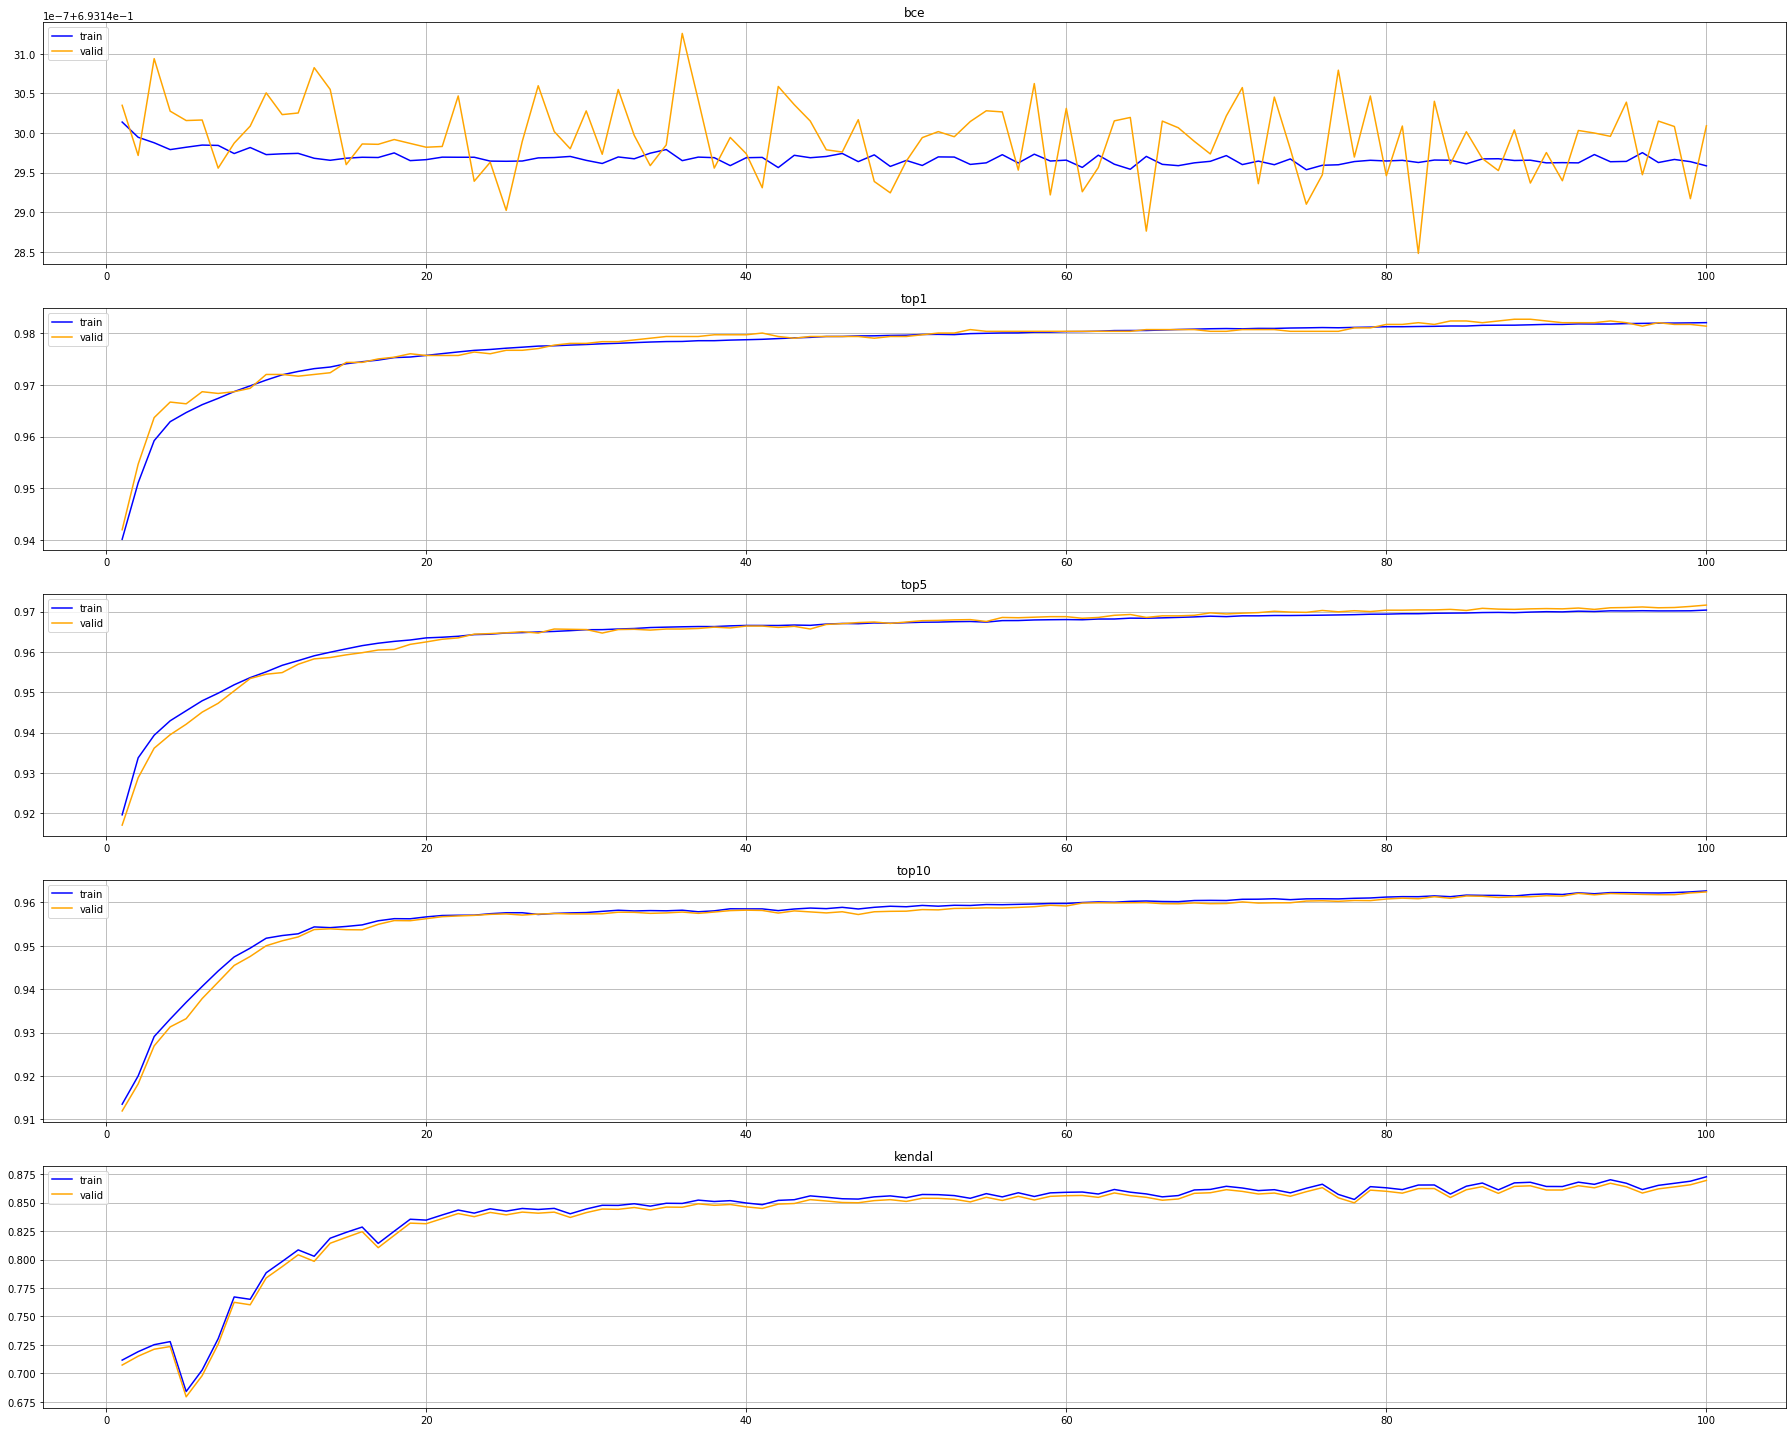

In [45]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    

# Baseline

In [ ]:
G_nx = nx.readwrite.edgelist.read_edgelist(synthetic[0], delimiter="\t")
G_nk = nk.nxadapter.nx2nk(G_nx)
G_pyg = from_networkx(G_nx)

In [ ]:
G_nx

In [ ]:
G_nk

In [ ]:
G_pyg

In [ ]:
G_pyg_ = to_data(synthetic[0], between[0])

In [ ]:
G_pyg_.y

In [ ]:
G_nx_ = G_pyg_

## RK (DIAM)

ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [ ]:
ab = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
ab.run()

In [ ]:
ab.scores()

In [ ]:
top_n_percentage(np.array(ab.scores()), G_pyg_.y, k=1)

In [ ]:
kendal_tau_distance(np.array(ab.scores()), G_pyg_.y)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "rk.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.scores()

In [ ]:
top_n_percentage(np.array(kadabra.scores()), G_pyg_.y, k=500)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "kadabra.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

For the value of k, we set it to be 20% of the diameter of the network

In [ ]:
def KbcBetweenness(G, k):
    
    if k < 2:
        k = 2.0
        
    inf = float('inf')

    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0

    return kBC

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    for edge_list, score in zip(synthetic, between):
        
        
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        diameter = nx.algorithms.distance_measures.diameter(G_nx)
        start = time.time()
        result = KbcBetweenness(G_nx, diameter * 0.2)
        end = time.time()
        
        result = [v for k, v in sorted(result.items(), key=lambda  item: int(item[0]), reverse=False)]
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(result), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(result), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(result), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(result), G_pyg.y, k=10))
        
    json.dump(jsn, f)

In [ ]:
G_pyg

## DrBC

In [ ]:
with open(os.path.join(setting.root, "drbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    model.eval()
    model = model.to("cpu")
    for edge_list, score in zip(synthetic, between):
#         G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
#         G_nk = nk.nxadapter.nx2nk(G_nx)
        data = to_data(edge_list, score)
        
        start = time.time()
        bc_pr = model(data)
        end = time.time()

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
        jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
        jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
        jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))
        
    json.dump(jsn, f)

## Node2Vec

# Youtube

In [ ]:
yt_nx = utils.to_networkx(yt_data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)

In [ ]:
yt_nx

In [ ]:
from_networkx(yt_nx)

In [ ]:
with open(os.path.join(setting.root, "youtube.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    yt_pyg = to_data(yt[0], yt_score[0], y_sep=r":")
    yt_nx = utils.to_networkx(yt_pyg, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
    yt_nk = nk.nxadapter.nx2nk(yt_nx)
    
    
    ### RK
    method = nk.centrality.ApproxBetweenness(yt_nk, epsilon=0.1)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nRK")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    ### Kadabra
    method = nk.centrality.KadabraBetweenness(yt_nk, 0.05, 0.8)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nKadabra")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    model.eval()
    start = time.time()
    bc_pr = model(yt_pyg)
    end = time.time()

    print("\nDrBC")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(bc_pr, yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=10)))

        
#     json.dump(jsn, f)

In [ ]:
bc_pr.size()

# Visualize all result

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())

    x = np.linspace(1, 30, 30)

    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        ax.plot(x, rk[key], "o")
        ax.plot(x, kbc[key], "o")
        ax.plot(x, kadabra[key], "o")
        ax.plot(x, drbc[key], "o")
        ax.legend(["rk", "kbc", "kadabra", "drbc"], loc='center right', bbox_to_anchor=(1, 0.5))

        ax.set_xticks(x)
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(os.path.join(setting.root, "synthetic_each.png"), facecolor="white")

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([rk[key], kbc[key], kadabra[key], drbc[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        ### Calculate mean and std
        print("\n{}".format(key))
        rk_ = np.array(rk[key])
        print("RK: mean={}, std={}".format(np.mean(rk_), np.std(rk_)))
        
        kbc_ = np.array(kbc[key])
        print("KBC: mean={}, std={}".format(np.mean(kbc_), np.std(kbc_)))
        
        kadabra_ = np.array(kadabra[key])
        print("KADABRA: mean={}, std={}".format(np.mean(kadabra_), np.std(kadabra_)))
        
        drbc_ = np.array(drbc[key])
        print("DrBC: mean={}, std={}".format(np.mean(drbc_), np.std(drbc_)))
        
    
    plt.setp(axs,  xticklabels=['rk', 'kbc', 'kadabra', "drbc"])
    plt.savefig(os.path.join(setting.root, "synthetic_box.png"), facecolor="white")
    
    